In [1]:
# standard imports
%matplotlib inline
from basicimports import *

# location, wd and dir contents
forme_loc = home+"formEox/"
wd = home + "ca1vac/"
print("working directory contains \n{}".format(os.listdir(wd)))

Last ran on /home/tboland1/Dropbox/Crozier Group User- Tara Boland/pymatgen from 2019-02-27 10:40:08.686833. 

home is /home/tboland1/Dropbox/TaraB/DFT/
working directory contains 
['final', 'notes', 'o_configs', 'ca_charged', 'initial', 'old', 'migration']


# Migration Energy In the Presence of Ca Dopants 

### TO DO's 
Section 3.4 

NEB needs to have code left -- see section notes

Sub methods based on Pratik's formula for finding the migration energy are mostly done. Need to have spE calculations synced to agave and ran for isif3 and finish running isif2 methods.

## 0.0 Doping CeO$_{2}$ with 1 Ca atom 
* This is done for a 2x2x2 conventional supercell. 
* Remove 1 O atom
* Relax structure using isif3.
*See notebook Formation Energy of Oxygen Vacancy In CeO$_2$ 1 Vacancy for the details of this calculation.

In [2]:
# get init struct from prev calc, replace Ce # 7 == Ca 
path_novac = os.path.abspath(forme_loc+"nfa0-1vceo2/novac/POSCAR")
novac_struc = Poscar.from_file(filename=path_novac).structure
#find the Ce atom to replace with a Ca atom by looking @  the structure
show_struct_ase(novac_struc)

ce_replace = 7
novac_struc[ce_replace]

PeriodicSite: Ce (5.5022, 5.5022, 5.5022) [0.5000, 0.5000, 0.5000]

# 1.0 Creating DFT Structures

## 1.1 Initial State Structure
**1.1.0 Find NN to Dopant Site**
* Now we have the structure w/o a vacancy in it. Let's export this to look at how the presence of a Ca atom influences the structure.

We need to
* Initialize the NN finder toolbox 
* Assign atoms their formal charge.

**1.1.1 Remove O$_{vac}$**
* Get the NN for Ce atom #7
* Get ox-ox bond distance 
* Remove an O atom 
* Record the removed atom

In [3]:
# get NN for Ca dopant, create vac, remove O, create Ca doped struct
from pymatgen.analysis.local_env import CrystalNN
novac_struc.add_oxidation_state_by_element({"Ce":4,"O":-2,"Ca":2})
cNN = CrystalNN(cation_anion=True,distance_cutoffs=([0,3]))


# get the NN data from the structure
nn_data = cNN.get_nn_data(structure=novac_struc, n=ce_replace)

# get vacancy site information
remove_atom = nn_data.all_nninfo.pop(2)['site_index']
print("The number of NN is {}.\n"
      'Remove oxygen atom number {}.'.format(len(nn_data.all_nninfo),
                                     remove_atom))

# copy the pure structure to make doped structure.
doped_struc = novac_struc.copy()

# create dopant
doped_struc[ce_replace] = 'Ca'

# write out the  poscar for the ca_charged DFT sim
doped_struc.remove_oxidation_states()
doped_struc.to(filename=wd+'ca_charged/relax-v0/POSCAR_init',
               fmt='POSCAR')

# create vacancy
del doped_struc[remove_atom]

# get oxygen oxygen bond distance
ox_ox_bond = doped_struc.get_distance(i=88, j=49)
print("The composition is {}.\nThe O-O bond distance is {:0.2f}".format(
    doped_struc.composition, ox_ox_bond))

# unrelaxed ca ceo2 structure
ca_neb0_struc = doped_struc.copy()

## Ca_Charged DFT Files
Create the VASP simulation files: INCAR, POTCAR, KPOINTS, & parallel.sh files for ca_charged system. Record how the sync from cluster was done @ each step.

In [5]:
# create initial DFT files for ca_charged, create struct ca1vac
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
path = wd+'ca_charged/'
struct = Poscar.from_file(path+'relax-v0/POSCAR_init').structure
# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Ca No vac initial relax"
relax_init_incar.pop('NPAR')
relax_init_incar['KPAR']  = 4
relax_init_incar['ENCUT'] = 520
relax_init_incar['ISIF']  = 3
relax_init_incar['ISPIN'] = 1
relax_init_incar['NSIM']  = 18
relax_init_incar['EDIFF'] = 1.0e-03
relax_init_incar['NELM'] = 80             
relax_init_incar['EDIFFG'] = -0.1
relax_init_incar['NSW'] = 100
                 
ul = [-1]*len(struct.symbol_set)
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'relax-v0/INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'relax-v0/KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

with open(path + "asinghargpu1.sh", "w") as f:
    f.write(
            '#!/bin/bash\n'
            '#SBATCH -p asinghargpu1 # Each node has one 1080Ti.\n'
            '#SBATCH -n 4            # Number of GPUs to use\n'
            '#SBATCH -c 8            # This will grab the CPUs on the same node. No need to change.\n'
            '#SBATCH -J CaCharged\n'
            '#SBATCH -t 1-00:00\n#SBATCH --gres=gpu:1\n'
            '#SBATCH -q wildfire \n'
            '#SBATCH -o error.%j.out\n'
            '\n'
            "module purge\n"
            "cd /scratch/tboland1/ca1vac/ca_charged/\n"
            '\n'
            "module load vasp/5.4.4-gpu\n"
            'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"'
            + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP=slurm " + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP_EXEC=srun" + '\n'
            '\n'
            '\n'
            "mpiexec.hydra vasp_gpu")

In [6]:
# create Spin Relax INCAR for ca_charged
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Ca vo vac spin relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=520
relax_init_incar['ISIF']=3
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['NSIM']  = 6
relax_init_incar['NSW'] = 100
relax_init_incar['ISPIN'] = 2
ul = [-1]*len(struct.symbol_set)
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-06
relax_init_incar.write_file(path+'relax-v1/INCAR')

In [7]:
# create spE INCAR for ca_charged (done)
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Ca No vac Spin spE"
relax_init_incar['NSIM']=18
relax_init_incar['KPAR']=4
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['ISPIN']=2
relax_init_incar.pop('NPAR')
relax_init_incar.pop('EDIFFG')
relax_init_incar['NSW']=0
relax_init_incar['IBRION']=-1
ul = [-1]*len(struct.symbol_set)
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-04
relax_init_incar.write_file(path+'spE/INCAR')

### Analysis: Ca_charged
* DOS
* Energy

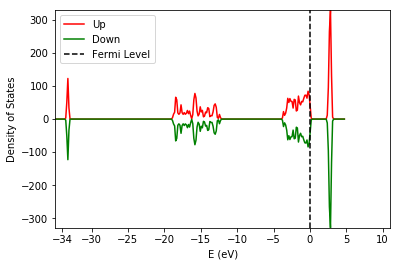

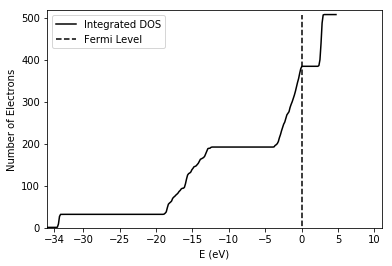

In [8]:
# DOS Plot
plot_density_of_states(path+'spE/')

In [9]:
# Energy
E = Oszicar(path + 'spE/OSZICAR')
print("The final energy of the system is for:"
      " \nE_cacharged is {:0.2f}.".
      format(E.final_energy))

The final energy of the system is for: 
E_cacharged is -770.95.


### 1.1.2 Initial State Structure

After manipulating the 2x2x2 CeO$_2$ structure by replacing 1 Ce atom with a Ca atom, creating the dft files for ca_charged system and inducing 1 vacancy in the structure it is now time to write the files for ca1vac.

Summary of the code above:
* Create structures for
    * W/ 1 Ca atom (no vacancy)
        * DFT files and sync data
    * W/ 1 Ca atom and 1 O$_{vac}$
    
### Ca1vac DFT files

In [10]:
# initial relax (done)
structs = [ca_neb0_struc]
labels = ["POSCAR_init"]
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    file.remove_oxidation_states()
    file.to(fmt='POSCAR', 
            filename=wd + 'initial/relax-v0/' + label)
    
    # create incar
    relax_init_incar = Incar.from_file(wd + '../INCAR')
    relax_init_incar['System']= "Ca 1 vac initial relax"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 400
    relax_init_incar['ISIF']   = 2
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 150
    relax_init_incar['EDIFFG'] = -0.01
    relax_init_incar['EDIFF']  = 0.1E-04
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
    relax_init_incar.write_file(path+'relax-v0/INCAR')
    
    # create KPOINTS (4x4x4 kp mesh)
    kp_file = Kpoints.automatic_density(structure=file,kppa=6000)
    #kp_file.write_file(path+'relax-v0/KPOINTS')
    
    # create POTCAR
    potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
                functional="PBE")
    potcar.write_file(path+'POTCAR')
    
ca_neb0_struc = doped_struc.copy()
show_struct_ase(ca_neb0_struc)

In [11]:
# 2nd relax (done)
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    # create incar
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac 2nd relax"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 150
    relax_init_incar['EDIFFG'] = -0.01
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
    relax_init_incar['EDIFF']  = 0.1E-04
    
    relax_init_incar.write_file(path+'relax-v1/INCAR')

In [12]:
# spE (done)
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    # create incar
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac spE"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 400
    relax_init_incar['ISIF']   = 2
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 0
    relax_init_incar['IBRION'] = -1
    relax_init_incar['EDIFF']  = 0.1E-04
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
    
    relax_init_incar.pop('EDIFFG')
    relax_init_incar.pop('POTIM')    
    
    relax_init_incar.write_file(path+'spE/INCAR')

 Bader run

In [13]:
# grid 2 (port & run)
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    # create incar
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac BADER"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 2
    relax_init_incar['ENCUT']  = 400
    relax_init_incar['ISIF']   = 2
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 0
    relax_init_incar['IBRION'] = -1
    relax_init_incar['EDIFF']  = 0.1E-04
    
    relax_init_incar['NGXF']   = 216
    relax_init_incar['NGYF']   = 216
    relax_init_incar['NGZF']   = 216
    relax_init_incar['LAECHG'] = '.TRUE.'  
    
    relax_init_incar.pop('EDIFFG')
    relax_init_incar.pop('POTIM')
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
    
    relax_init_incar.write_file(path+'bader/grid-2/INCAR')

### Analysis for  Ca1vac: Initial State
* DOS
* System Energy

In [14]:
# sys E
E_ca1vac = Oszicar(path + 'spE/OSZICAR')
print("The final energy of the system is for:"
      " \nE_ca1vac is {:0.2f}.".
      format(E_ca1vac.final_energy))

The final energy of the system is for: 
E_ca1vac is -767.42.


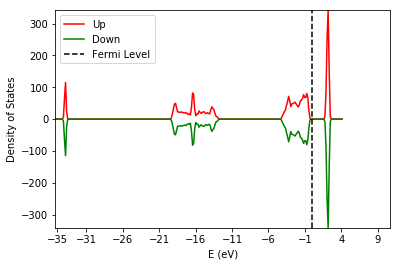

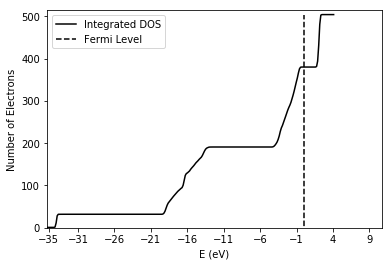

In [15]:
# ca1vac dos
plot_density_of_states(wd+'initial/spE/')

# Ca1vac Transition State

In [ ]:
# make transition state
ox_ox = struct.distance_matrix[38][45]
struct.translate_sites(
    indices=77,
    vector=[0, 0, ox_ox/2],
    frac_coords=False,
    to_unit_cell=True)

migrating = 77
shell = 1
from pymatgen.analysis.local_env import CrystalNN
cNN = CrystalNN(cation_anion=True, distance_cutoffs=[0,2])

# cNN requires the oxidation state
struct.add_oxidation_state_by_element({'Ce':4,'O':-2})

# find the NN for the migrating site
NN_site_idx = [
    nn['site_index']
    for nn in cNN.get_nn_shell_info(struct, migrating, shell)
]
NN_site_idx.append(migrating) # include the vacancy as a site
struct.remove_oxidation_states()

tags = []
for site in struct:
    if struct.index(site) in NN_site_idx and site.specie.symbol == "Ce":
        tags.append(['T'] * 3)
    elif struct.index(site) in NN_site_idx and site.specie.symbol == "O":
        tags.append(["T",'T','F'])
    else :
        tags.append(['T'] * 3)
spins = ['ispin1', 'ispin2']
trans = ['pos','mid','neg']
shifts = [0.15,0,-0.15]

from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
for spin in spins:
    path = wd+"ca1vac/migration/isif2/" + spin + '/'
    try :
        os.makedirs(path)
    except:
        path = path
    for tran,shift in zip(trans,shifts):
        


In [2]:
### initial relax (done)
# create the migration pathway calculation
spins = ['ispin1', 'ispin2']
trans = ['pos','mid','neg']
shifts = [0.15,0,-0.15]

from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
for spin in spins:
    path = wd+"ca1vac/migration/isif2/" + spin + '/'
    try :
        os.makedirs(path)
    except:
        path = path
    for tran,shift in zip(trans,shifts): 
    
        # create incar
        relax_init_incar = Incar.from_file(wd + '../INCAR')
        relax_init_incar['System']= "Ca 1 vac initial relax"
        relax_init_incar['NPAR']   = 2
        relax_init_incar['KPAR']   = 1
        relax_init_incar['ENCUT']  = 400
        relax_init_incar['ISIF']   = 2
        relax_init_incar['ISPIN']  = 1
        relax_init_incar['NSW']    = 150
        relax_init_incar['EDIFFG'] = -0.01
        relax_init_incar['EDIFF']  = 0.1E-05

        ul = [-1]*len(struct.symbol_set)
        uu = [0]*len(struct.symbol_set)
        counter = 0
        for element in list(struct.symbol_set):
            if element == 'Ce':
                ul[counter] = 3    
                uu[counter] = 5 
            counter += 1
        relax_init_incar['LDAUL'] = ul
        relax_init_incar['LDAUU'] = uu
        relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
        relax_init_incar.write_file(path+'INCAR')

        # create KPOINTS (4x4x4 kp mesh)
        kp_file = Kpoints.automatic_density(structure=file,kppa=50)
        kp_file.write_file(path+'KPOINTS')

        # create POTCAR
        potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
                    functional="PBE")
        potcar.write_file(path+'POTCAR')

        # slurm for each calc
            with open(path + "parallel.sh", "w") as f:
                f.write(
                    "#!/bin/bash\n"

                    "#SBATCH -J V" + spin + tran + " \n"

                    "#SBATCH -t 0-06:00\n"
                    "#SBATCH -n 56\n"

                    "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
                    "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"

                    "cd /scratch/tboland1/1vac/migration/isif2/"+ spin + '/' + tran + '/' +"\n"

                    "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
                    'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
                    "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
                    "mpiexec.hydra vasp_gam")
        show_struct_ase(struct)

IndentationError: unexpected indent (<ipython-input-2-70539af8955a>, line 50)

In [ ]:
# 2nd relax (done)
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    # create incar
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac 2nd relax"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 150
    relax_init_incar['EDIFFG'] = -0.01
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] = [0]*len(struct.symbol_set)
    relax_init_incar['EDIFF']  = 0.1E-04
    
    relax_init_incar.write_file(path+'relax-v1/INCAR')

In [ ]:
# spE (done)
for file, label in zip(structs, labels):
    path = wd + 'initial/'
    
    # create incar
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac spE"
    relax_init_incar['NPAR']   = 4
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 400
    relax_init_incar['ISIF']   = 2
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['NSW']    = 0
    relax_init_incar['IBRION'] = -1
    relax_init_incar['EDIFF']  = 0.1E-04
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
    
    relax_init_incar.pop('EDIFFG')
    relax_init_incar.pop('POTIM')    
    
    relax_init_incar.write_file(path+'spE/INCAR')

###  1.2.0 Final State Structure
The initial state structure will serve as the starting structure for a migration energy calculation. Next
* Export initial state Ca doped structure as POSCAR file
* Relax the structure using VASP.
* Import the structure after.

**1.2.1 Create FSS**
* Move an O atom from one site to another using unrelaxed Initial state structure.
* Export this structure as the final state POSCAR.
* Relaxed on supercomputer.

In [ ]:
# read in relaxed poscar and the
ca_neb5_struc = Poscar.from_file(
    filename=wd + "initial/POSCAR").structure

# displace the oxyge atoms to get final state for neb calculation.
ca_neb5_struc.translate_sites(
    indices=49,
    vector=[0, 0, -ox_ox_bond],
    frac_coords=False,
    to_unit_cell=True)
show_struct_ase(ca_neb5_struc)

structs = [ca_neb5_struc]
labels = ["POSCAR_unrel_ca_neb5"]
for file, label in zip(structs, labels):
    file.remove_oxidation_states()
    file.to(fmt='POSCAR', filename=label)

### 1.3.0 Midpoint/Transition State Structure
* Use nebmake.pl to create mid point structure
* See data below with all other imported data below in the DFT Results section

* Use relaxed structures to make the NEB file when using nebmake.pl

# 2.0 Analysis Migration Energy.

## 2.1 Ca Relaxed Initial, Mid, & Final State
* Replace Ca @ site {{ce_replace}}
* Initial and final state structures have differing energies.
* Check incar's
    * only differences are in the KPAR value used
* Check POSCAR
    * **Nope** lattices are different for ca$_{neb5}$ structure.
        * ca$_{neb0}$ has vasp precision for structs
    * **Nope** ca$_{neb5}$ has pymatgen's default prec for decimals 6
    * **Nope** precision of the lattice constants could be the origin of the 0.0049 eV difference...
        * it is also below the precision in meV/A in the calculations
    * **Nope** different symmetry between the 2 cells... (-_-)
        * redo with isym = 0 & re-check
* **Rez --> it should not matter**
* **Arunima --> increase kp - waste of time**
    * Need to check the KP vs Energy for the precision in which the E can be determined.  
    

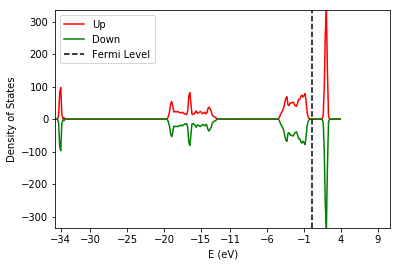

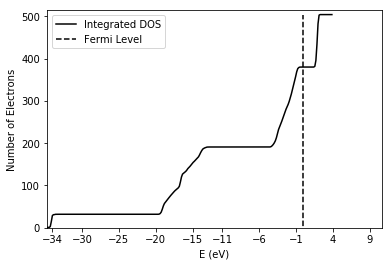

In [26]:
# ca1vac Trans DOS
plot_density_of_states(wd+'mid/spE/')

In [24]:
# E for *initial, final, trans state* structure
ca_Irelax = Oszicar(wd+'initial/OSZICAR')
print("The energy of the INITIAL state relaxed structure is    {:0.2f}.".format(
    ca_Irelax.final_energy))
ca_Frelax = Oszicar(wd+'final/OSZICAR')
print("The energy of the FINAL state relaxed structure is      {:0.2f}.".format(
    ca_Frelax.final_energy))
ca_Mrelax = Oszicar(wd+'mid/spE/OSZICAR')
print("The energy of the TRANSITION state relaxed structure is {:0.2f}.".format(
    ca_Mrelax.final_energy))

The energy of the INITIAL state relaxed structure is    -767.42.
The energy of the FINAL state relaxed structure is      -767.42.
The energy of the TRANSITION state relaxed structure is -766.62.


In [25]:
# migration energy
E_mig = ca_Mrelax.final_energy - ca_Frelax.final_energy
print("The migration energy for an O_vac {:0.2f} eV".format(E_mig))

The migration energy for an O_vac 0.80 eV


# 3.0 Ensure Crystallographic Uniqueness
Use ODST to confirm that only 1 1NN unique configuration exists. For the structures where the O$_{vac}$ is in NN shells which are not the 1$^{st}$ shell gather system energy data.

This method for finding the unique structures serves as a sanity check for 2 Ca atoms which is performed later.

Below, there are benchmarks for the configuration finder code I developed using pymatgen functions. The structures are searched for
* 1x1x1 conventional unit cell w/ 1 Ca dopant w/o the inclusion of an oxygen vacancy
* 1x1x1 conventional unit cell w/ 1 Ca dopant & the inclusion of an oxygen vacancy


## 3.1 ODST *w/o* O$_{vac}$ Conventional Unit Cell

Let's do this for the conventional unit cell.
Let the generator:
* **1x1x1 Conventional Unit Cell**
* find all Ca locations
* initially use a conventional unit cell

**Summary**

That seems like a reasonable amount of structures. Let's look at how many are unique from our set.

Timing for Run: 2 sec

In [16]:
# Define the Specie, Create the Structure, Use OrdDisTran generator
con_Ca = 0.25
con_Ce = 1-con_Ca
con_O = 8/8
specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": con_O}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494), specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

# obtain a copy of the structure 
struct = structure.copy()

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation

# generate all possible crystallographic configurations
odst = OrderDisorderedStructureTransformation()
odst_structs = odst.apply_transformation(struct, return_ranked_list=10000)
print(('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_structs), odst_structs[0]['structure'].composition)))

# Remove duplicated structures
from pymatgen.analysis.structure_matcher import StructureMatcher

# initialize the object
matcher = StructureMatcher()

# Pass a list of structures to the matcher
# so the SM can group the structures by their similarity
matches = matcher.group_structures([d["structure"] for d in odst_structs])

# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
groups = [matches[i][0] for i in range(len(matches))]
# the total number of unique structures found
unique_count = len(groups)
# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

There is a total of 4 structure(s) created using the ODST.
The composition is Ca2+1 Ce4+3 O2-8.

The total number of unique structures found is 1.
The number frequency with which each structure occures is 
	 4.


## 3.2 ODST w/ O$_{vac}$ Conventional Unit Cell

Let's do this for the conventional unit cell.
Let the generator:
* find all Ca locations & all O$_{vac}$ locations @ the same time
* initially use a conventional unit cell

**Summary**

For initial structure search -- Comments: Now that's a lot of configuration for just one dopant & vacancy in a conventional unit cell... Let's remove duplicate structures now.

So the behavior seems logical for out initial structures. Let's repeat this only using a bigger cell 2x2x2 supercell since it is more realistic.

Timing for Run: 2 sec 

In [17]:
# Define the Specie, Create the Structure, Use OrdDisTran generator
con_Ca = 0.25
con_Ce = 1-con_Ca
con_O = 7/8
specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": con_O}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494), specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

# obtain a copy of the structure 
struct = structure.copy()

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation

# generate all possible crystallographic configurations
odst = OrderDisorderedStructureTransformation()
odst_structs = odst.apply_transformation(struct, return_ranked_list=10000)
print(('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_structs), odst_structs[0]['structure'].composition)))

# Remove duplicated structures
from pymatgen.analysis.structure_matcher import StructureMatcher

# initialize the object
matcher = StructureMatcher()

# Pass a list of structures to the matcher
# so the SM can group the structures by their similarity
matches = matcher.group_structures([d["structure"] for d in odst_structs])

# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
groups = [matches[i][0] for i in range(len(matches))]
# the total number of unique structures found
unique_count = len(groups)
# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

There is a total of 32 structure(s) created using the ODST.
The composition is Ca2+1 Ce4+3 O2-7.

The total number of unique structures found is 1.
The number frequency with which each structure occures is 
	 32.


## 3.3 ODST w/ O$_{vac}$ Super Cell
Results are pickled
* 1 Ca dopant
* 1 O$_{vac}$
* 2x2x2 super cell

Even when loading the pickled data the cell runs for 14 seconds

In [18]:
# repeat ^ but now make it a supercell
# change just Ca ( enter total # of Ca you want)
Ca = 1
con_Ca = (Ca)/32
con_Ce = 1-con_Ca
con_O = (64-Ca)/64

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": con_O}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494), specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

# obtain a copy of the structure 
struct = structure.copy()
struct.make_supercell([2,2,2])

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation

# generate all possible crystallographic configurations
odst = OrderDisorderedStructureTransformation()
odst_structs = odst.apply_transformation(struct, return_ranked_list=10000)
print(('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_structs), odst_structs[0]['structure'].composition)))

# Remove duplicated structures
from pymatgen.analysis.structure_matcher import StructureMatcher

# initialize the object
matcher = StructureMatcher()

## PICKLED
#matches = matcher.group_structures([d["structure"] for d in odst_structs])
# load Pickled var to save time
with open("../pkl/def2ca_odst_matches1Ca1Ov2cubed.pkl", 'rb') as f:
    matches = pickle.load(f)

# Original pickling of 
#with open("../pkl/def2ca_odst_matches1Ca1Ov2cubed.pkl",'wb') as f:
#    pickle.dump(matches,f)

# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
groups = [matches[i][0] for i in range(len(matches))]
# the total number of unique structures found
unique_count = len(groups)
# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occurres is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

There is a total of 2048 structure(s) created using the ODST.
The composition is Ca2+1 Ce4+31 O2-63.

The total number of unique structures found is 4.
The number frequency with which each structure occurres is 
	 256 768 768 256.


In [19]:
# Shift Ca to center u.c. Cod Edt: entr type of defect to center
defect_type = 'Ca2+'

for struct in groups:
    # get all the indices in the structure to translate
    indices = [ index for index in range(len(struct))]
    # find the defect site in the structure, pull out its coordinates
    defect_sites = [
        list(struct[defect_site].coords) for defect_site in [
            struct.index(site) for site in struct
            if str(site.specie) == defect_type
        ]
    ]
    
    # setup the translation vector to pass to translate sites 
    trans_flag=[0,0,0]
    # loop over the defect coords and trip flag for position which are 0
    for index in range(len(defect_sites[0])):
        if defect_sites[0][index] == 0:
            trans_flag[index] = 0.5
            #print(trans_flag)
    # now translate all the sites for the structure !! :D 
    struct.translate_sites(indices,trans_flag)

Create INCAR, POTCAR, KPOINTS and batch script for o_configs

In [20]:
# creating dft files
counter = 0
for struct in groups:
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    ## edit
    path = wd+'o_configs/'+str(counter)+'/'
    #os.makedirs(path)
    # create poscar
    struct.remove_oxidation_states()
    struct.to(filename = path+'relax-v0/POSCAR_'+str(counter), fmt = 'POSCAR')
    #show_struct_ase(struct)
    # create INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "O Config " + str(counter) + " initial relax"
    relax_init_incar['NPAR']=2
    relax_init_incar['KPAR']=1
    relax_init_incar['ENCUT']=520
    relax_init_incar['ISIF']=3
    relax_init_incar['EDIFFG']=-0.01
    relax_init_incar['EDIFF']=0.1E-05
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    count = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[count] = 3    
            uu[count] = 5 
        count += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
    relax_init_incar.write_file(path+'relax-v0/INCAR')
    
    # create KPOINTS
    kp_file = Kpoints.automatic_density(structure=struct,kppa=50)
    kp_file.write_file(path+'relax-v0/KPOINTS')
    
    # create POTCAR
    potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
                functional="PBE")
    potcar.write_file(path+'relax-v0/POTCAR')
    
    # slurm for each calc
    with open(path + "relax-v0/parallel.sh", "w") as f:
        f.write(
            "#!/bin/bash\n"
            
            "#SBATCH -J oCf" + str(counter) + " \n"
            
            "#SBATCH -t 0-12:00\n"
            "#SBATCH -n 56\n"
            
            "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
            "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
            "#SBATCH --mail-user=tboland1@asu.edu\n"
            "#SBATCH --mail-type=end\n\nmodule purge\n"
            
            "cd /scratch/tboland1/ca1vac/o_configs/"+ str(counter) + "/\n"
            
            "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
            'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
            "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
            "mpiexec.hydra vasp_std")
        
    counter += 1 

In [21]:
# high kp 
counter = 0
for struct in groups:
    from pymatgen.io.vasp.inputs import Incar, Kpoints
    ## edit
    path = wd+'o_configs/'+str(counter)+'/'
    
    # create INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    ## edit
    relax_init_incar['System']= "O Config " + str(counter) + " High KP relax"
    relax_init_incar['NPAR']=2
    relax_init_incar['KPAR']=1
    relax_init_incar['ENCUT']=520
    relax_init_incar['ISIF']=3
    relax_init_incar['ISPIN']=2
    relax_init_incar['EDIFFG']=-0.01
    relax_init_incar['EDIFF']=0.1E-05
    uu = [0]*len(struct.symbol_set)
    
    count = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[count] = 3    
            uu[count] = 5 
        count += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
    relax_init_incar.write_file(path+'relax-v1/INCAR')
    
    # create KPOINTS
    kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
    kp_file.write_file(path+'relax-v1/KPOINTS')
        
    counter += 1 

In [22]:
# write final energy files -- spE
counter = 0
for struct in groups:
    ## edit
    path = wd+'o_configs/'+str(counter)+'/'
    
    # create INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 1 vac spin final E"
    relax_init_incar['NPAR']=2
    relax_init_incar['KPAR']=1
    relax_init_incar['ENCUT']=400
    relax_init_incar['ISIF']=2
    relax_init_incar['NSW']=0
    relax_init_incar['IBRION']=-1
    uu = [0]*len(struct.symbol_set)
    count = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[count] = 3    
            uu[count] = 5 
        count += 1
    relax_init_incar['LDAUL'] = ul
    relax_init_incar['LDAUU'] = uu
    relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
    relax_init_incar['ISPIN']=2
    
    relax_init_incar.pop('EDIFFG')
    relax_init_incar.pop('POTIM')
    
    relax_init_incar.write_file(path+'spE/INCAR')
    counter += 1

## Analysis for Ca$_1$Ce$_{31}$O$_{vac}$ Configs

The DOS Ca O_vac config 0.


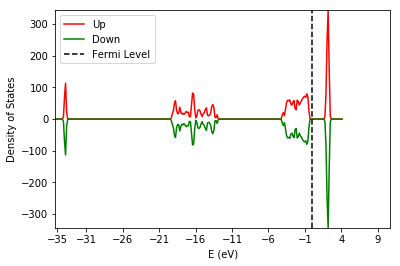

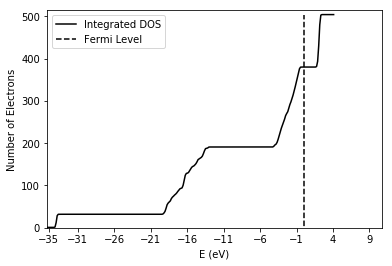

The DOS Ca O_vac config 1.


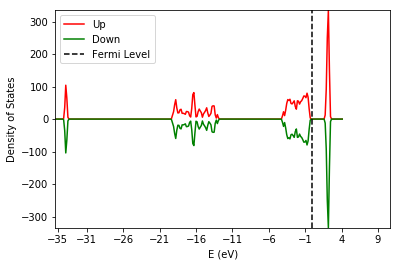

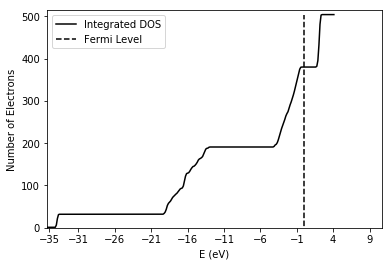

The DOS Ca O_vac config 2.


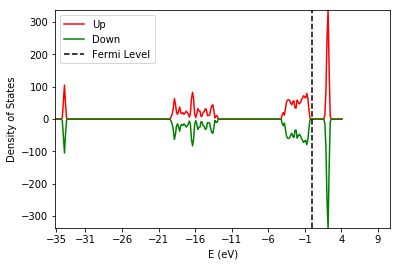

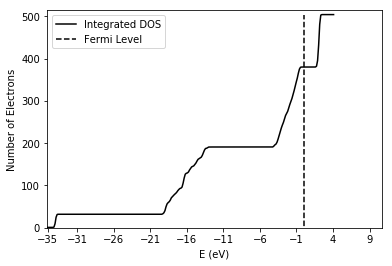

The DOS Ca O_vac config 3.


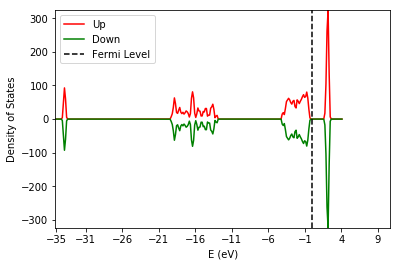

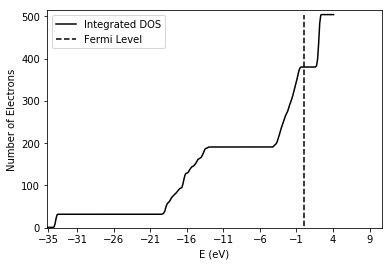

In [23]:
# DOS Plot
counter = 0
for struct in groups:
    ## edit
    path = wd+'o_configs/'+str(counter)+'/'
    print("The DOS Ca O_vac config {}.".format(counter))
    plot_density_of_states(path+'spE/')
    counter += 1

In [24]:
# get sys E's
counter = 0
for struct in groups:
    ## edit
    path = wd+'o_configs/'+str(counter)+'/'
    E = Oszicar(path + 'spE/OSZICAR')
    print("The System Energy for Ca O_vac config {} is {:0.2f}."
          .format(counter,E.final_energy))
    counter += 1

The System Energy for Ca O_vac config 0 is -767.44.
The System Energy for Ca O_vac config 1 is -767.13.
The System Energy for Ca O_vac config 2 is -767.03.
The System Energy for Ca O_vac config 3 is -766.99.


In [25]:
# show structs
counter = 0
for struct in groups:
    path = wd+'o_configs/'+str(counter)+'/'
    struct = Poscar.from_file(path+'POSCAR').structure    
    show_struct_ase(struct)
    counter += 1

## 3.4 Migration Energy -- work in progress
Only neb section is left to code and relax.
### 3.4.0 NEB Method for 1NN Vacancy Migration
* Take structure #0 from the groups list of unique structures
* Make 2 neb calculations
    * with only 1 image
    * with 3 images

In [ ]:
init_struct = groups[0]
#show_struct_ase(init_struct)

Translate oxygen number 54 one oxy-oxy bond distance in the -z direction
* using the distance matrix you get a 2D matrix filled with each atoms interatomic distance spacing in order form 0 to N for dat[N] and it follows that same logic for the second matrix in order from 0-N
    * so if you want to know all the distances for atom number x you type dat[x]
    * then you want to know the distance to atom index y you simply type dat[x][y]. 
    * Very useful. Correlates with ase's atom_index

In [ ]:
def SelectDynNN(structure,NN_site_idx):
    '''
    Sets the selective dynamics tags for a migration energy
    calculation. When given a structure and a site index + NN list
    another list (Nx3 array) is created which specify the selective
    dynamics tags for the xyz direction for each atom with True for 
    the NN sites and the migrating atom frozen perpendicular to the
    path. 
    
    struct is the structure you want to to get the selective 
            dynamics tags for
    NN_site_idx a list of sites which you will allow to move and the
                last is the migrating atom which u want to not move 
                perpendicular to the migration path.
    '''
    tags = []
    for site in structure:
        if structure.index(site) in NN_site_idx and site.specie.symbol == "Ce":
            tags.append(['T'] * 3)
        elif structure.index(site) in NN_site_idx and site.specie.symbol == "O":
            tags.append(["T",'T','F'])
        else :
            tags.append(['F'] * 3)

    return tags

In [ ]:
# create selective dynamics tags, shift oxy mid - 0.15
mid_struct = init_struct.copy()
migrating = 54
mid_struct.translate_sites(migrating,[0,0,ox_ox/2-0.15],frac_coords=False)
struct = mid_struct

NN_site_idx = []
NN_site_idx.append(migrating) # include the vacancy as a site

# create a set of sdynamics tags for the entire structure
tags = SelectDynNN(struct,NN_site_idx)

In [ ]:
# create poscar file 
p = Poscar(mid_struct, selective_dynamics=tags)
p.write_file(filename=wd+'pratik_neb/neg/POSCAR_unrel')

In [ ]:
# INCAR, KP POTCAR TO NEG NEB PRATIK
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
## edit
path = wd + 'pratik_neb/neg/'
# create the structure
## edit
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
## edit
relax_init_incar['System']= "Pratik's Method: neg trans relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

# slurm for each calc
with open(path + "parallel.sh", "w") as f:
    f.write(
        "#!/bin/bash\n"

        "#SBATCH -J Pratneb \n"

        "#SBATCH -t 1-00:00\n"
        "#SBATCH -n 56\n"

        "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
        "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
        "#SBATCH --mail-user=tboland1@asu.edu\n"
        "#SBATCH --mail-type=end\n\nmodule purge\n"

        "cd /scratch/tboland1/ca1vac/pratik_neb/neg/\n"

        "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
        'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
        "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
        "mpiexec.hydra vasp_std")

In [ ]:
# spE 
path = wd + 'pratik_neb/neg/'
struct = p.structure
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Pratik's Method: neg trans spE"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['NSW']=0
relax_init_incar['IBRION']=-1
relax_init_incar['ISPIN']=2
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-05
relax_init_incar.pop('EDIFFG')
relax_init_incar.pop('POTIM')
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

* @ mid point

In [ ]:
# create selective dynamics tags, shift oxy to mid
mid_struct = init_struct.copy()
migrating = 54
mid_struct.translate_sites(migrating,[0,0,ox_ox/2],frac_coords=False)
struct = mid_struct

NN_site_idx = []
NN_site_idx.append(migrating) # include the vacancy as a site

# create a set of sdynamics tags for the entire structure
tags = SelectDynNN(struct,NN_site_idx)

In [ ]:
# create poscar file
p = Poscar(mid_struct, selective_dynamics=tags)
p.write_file(filename=wd+'pratik_neb/0/POSCAR_unrel')

In [ ]:
# INCAR, KP POTCAR TO mid NEB PRATIK
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
## edit
path = wd + 'pratik_neb/0/'
# create the structure
## edit
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
## edit
relax_init_incar['System']= "Pratik's Method: @ trans initial relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

# slurm for each calc
with open(path + "parallel.sh", "w") as f:
    f.write(
        "#!/bin/bash\n"

        "#SBATCH -J Pratneb0 \n"

        "#SBATCH -t 1-00:00\n"
        "#SBATCH -n 56\n"

        "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
        "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
        "#SBATCH --mail-user=tboland1@asu.edu\n"
        "#SBATCH --mail-type=end\n\nmodule purge\n"

        "cd /scratch/tboland1/ca1vac/pratik_neb/0/\n"

        "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
        'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
        "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
        "mpiexec.hydra vasp_std")

In [ ]:
# spE
path = wd + 'pratik_neb/0/'
struct = p.structure
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Pratik's Method: @ trans spE"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['NSW']=0
relax_init_incar['IBRION']=-1
relax_init_incar['ISPIN']=2
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.pop('EDIFFG')
relax_init_incar.pop('POTIM')
relax_init_incar.write_file(path+'INCAR')

Relax Pratik's method structure.
* Initial sync to cluster
    * rsync -azPn pratik_neb tboland1@agave.asu.edu:/scratch/tboland1/ca1vac/
* spE sync to cluster
    * rsync -azP --include='INCAR' --include='star/' --exclude='star' pratik_neb/ tboland1@agave.asu.edu:/scratch/tboland1/ca1vac/pratik_neb/

### Relax the 1NN 
* all structs relaxing on agave

In [ ]:
# @ neg
mid_struct = init_struct.copy()
migrating = 54
mid_struct.translate_sites(migrating,[0,0,ox_ox/2-0.15],frac_coords=False)
struct = mid_struct
shell = 1

# import the cNN to find the NN indices
from pymatgen.analysis.local_env import CrystalNN
cNN = CrystalNN(cation_anion=True, distance_cutoffs=[0,2])

# cNN requires the oxidation state
struct.add_oxidation_state_by_element({'Ce':4,'O':-2,'Ca':2})
# find the NN for the migrating site
NN_site_idx = [
    nn['site_index']
    for nn in cNN.get_nn_shell_info(struct, migrating, shell)
]
NN_site_idx.append(migrating) # include the vacancy as a site
struct.remove_oxidation_states()

# create a set of sdynamics tags for the entire structure
tags = SelectDynNN(struct,NN_site_idx)

p = Poscar(mid_struct, selective_dynamics=tags)
p.write_file(filename=wd+'pratik_neb_1NN/neg/POSCAR_unrel')

In [ ]:
# INCAR, KP POTCAR TO neg NEB PRATIK
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
## edit
path = wd + 'pratik_neb_1NN/neg/'
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
## edit
relax_init_incar['System']= "Pratik's Method: @ trans neg initial relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

# slurm for each calc
with open(path + "parallel.sh", "w") as f:
    f.write(
        "#!/bin/bash\n"

        "#SBATCH -J Prat1nnN \n"

        "#SBATCH -t 1-00:00\n"
        "#SBATCH -n 56\n"

        "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
        "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
        "#SBATCH --mail-user=tboland1@asu.edu\n"
        "#SBATCH --mail-type=end\n\nmodule purge\n"

        "cd /scratch/tboland1/ca1vac/pratik_neb_1NN/neg/\n"

        "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
        'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
        "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
        "mpiexec.hydra vasp_std")

In [ ]:
# spE files
path = wd + 'pratik_neb_1NN/neg/'
struct = p.structure
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Pratik's Method: @ trans neg spE"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['NSW']=0
relax_init_incar['IBRION']=-1
relax_init_incar['ISPIN']=2
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-05
relax_init_incar.pop('EDIFFG')
relax_init_incar.pop('POTIM')
relax_init_incar.write_file(path+'INCAR')

In [ ]:
# @ mid
mid_struct = init_struct.copy()
migrating = 54
mid_struct.translate_sites(migrating,[0,0,ox_ox/2],frac_coords=False)
struct = mid_struct
shell = 1

# import the cNN to find the NN indices
from pymatgen.analysis.local_env import CrystalNN
cNN = CrystalNN(cation_anion=True, distance_cutoffs=[0,2])

# cNN requires the oxidation state
struct.add_oxidation_state_by_element({'Ce':4,'O':-2,'Ca':2})
# find the NN for the migrating site
NN_site_idx = [
    nn['site_index']
    for nn in cNN.get_nn_shell_info(struct, migrating, shell)
]
NN_site_idx.append(migrating) # include the vacancy as a site
struct.remove_oxidation_states()

# create a set of sdynamics tags for the entire structure
tags = SelectDynNN(struct,NN_site_idx)

p = Poscar(mid_struct, selective_dynamics=tags)
p.write_file(filename=wd+'pratik_neb_1NN/0/POSCAR_unrel')

In [ ]:
# INCAR, KP POTCAR TO @ mid NEB PRATIK
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
## edit
path = wd + 'pratik_neb_1NN/0/'
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
## edit
relax_init_incar['System']= "Pratik's Method: @ trans initial relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

# slurm for each calc
with open(path + "parallel.sh", "w") as f:
    f.write(
        "#!/bin/bash\n"

        "#SBATCH -J Prat1nn0 \n"

        "#SBATCH -t 1-00:00\n"
        "#SBATCH -n 56\n"

        "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
        "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
        "#SBATCH --mail-user=tboland1@asu.edu\n"
        "#SBATCH --mail-type=end\n\nmodule purge\n"

        "cd /scratch/tboland1/ca1vac/pratik_neb_1NN/0/\n"

        "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
        'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
        "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
        "mpiexec.hydra vasp_std")

In [ ]:
# spE
relax_init_incar['NPAR']   = 2
relax_init_incar['KPAR']   = 1
relax_init_incar['ENCUT']  = 400
relax_init_incar['ISIF']   = 2
relax_init_incar['NSW']    = 0
relax_init_incar['IBRION'] = -1
relax_init_incar['ISPIN']  = 2
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']  = 0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.pop('EDIFFG')
relax_init_incar.pop('POTIM')
relax_init_incar.write_file(path+'INCAR')

In [ ]:
# @ pos
mid_struct = init_struct.copy()
migrating = 54
mid_struct.translate_sites(migrating,[0,0,ox_ox/2+0.15],frac_coords=False)
struct = mid_struct
shell = 1

# import the cNN to find the NN indices
from pymatgen.analysis.local_env import CrystalNN
cNN = CrystalNN(cation_anion=True, distance_cutoffs=[0,2])

# cNN requires the oxidation state
struct.add_oxidation_state_by_element({'Ce':4,'O':-2,'Ca':2})
# find the NN for the migrating site
NN_site_idx = [
    nn['site_index']
    for nn in cNN.get_nn_shell_info(struct, migrating, shell)
]
NN_site_idx.append(migrating) # include the vacancy as a site
struct.remove_oxidation_states()

# create a set of sdynamics tags for the entire structure
tags = SelectDynNN(struct,NN_site_idx)

p = Poscar(mid_struct, selective_dynamics=tags)
p.write_file(filename=wd+'pratik_neb_1NN/pos/POSCAR_unrel')

In [ ]:
# INCAR, KP POTCAR TO pos NEB PRATIK
from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
## edit
path = wd + 'pratik_neb_1NN/pos/'
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
## edit
relax_init_incar['System']= "Pratik's Method: @ trans pos initial relax"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['EDIFFG']=-0.01
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.write_file(path+'INCAR')

# create KPOINTS
kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
kp_file.write_file(path+'KPOINTS')

# create POTCAR
potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
            functional="PBE")
potcar.write_file(path+'POTCAR')

# slurm for each calc
with open(path + "parallel.sh", "w") as f:
    f.write(
        "#!/bin/bash\n"

        "#SBATCH -J Prat1nnP \n"

        "#SBATCH -t 1-00:00\n"
        "#SBATCH -n 56\n"

        "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
        "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"
        "#SBATCH --mail-user=tboland1@asu.edu\n"
        "#SBATCH --mail-type=end\n\nmodule purge\n"

        "cd /scratch/tboland1/ca1vac/pratik_neb_1NN/pos/\n"

        "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
        'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
        "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
        "mpiexec.hydra vasp_std")

In [ ]:
#spE
path = wd + 'pratik_neb_1NN/pos/'
struct = p.structure

# create INCAR
relax_init_incar = Incar.from_file(wd+'../INCAR')
relax_init_incar['System']= "Pratik's Method: @ trans pos spE"
relax_init_incar['NPAR']=2
relax_init_incar['KPAR']=1
relax_init_incar['ENCUT']=400
relax_init_incar['ISIF']=2
relax_init_incar['NSW']=0
relax_init_incar['IBRION']=-1
relax_init_incar['ISPIN']=2
## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
relax_init_incar['EDIFF']=0.1E-05
uu = [0]*len(struct.symbol_set)
counter = 0
for element in list(struct.symbol_set):
    if element == 'Ce':
        ul[counter] = 3    
        uu[counter] = 5 
    counter += 1
relax_init_incar['LDAUL'] = ul
relax_init_incar['LDAUU'] = uu
relax_init_incar['LDAUJ'] =  [0]*len(struct.symbol_set)
relax_init_incar.pop('EDIFFG')
relax_init_incar.pop('POTIM')
relax_init_incar.write_file(path+'INCAR')

Relax Pratik's method structure.
* synced to cluster
    * rsync -azPn pratik_neb_1NN/ tboland1@agave.asu.edu:/scratch/tboland1/ca1vac/pratik_neb_1NN/

The structures are all the same only the O$_{vac}$ has been moved from the NN position. If we repeat this analysis and exclude the option of having an O$_{vac}$ we can see the number of configurations which are likely to occur when the O$_{vac}$ is constrained to the 1NN.

**3.1 ODST w/o O$_{vac}$ Super Cell**

Let's give that a try. Let the generator:
* only use 1 Ca dopant
* 2x2x2 super cell 

In [ ]:
# repeat ^ but now make it a supercell
# change just Ca ( enter total # of Ca you want)
Ca = 1
con_Ca = (Ca)/32
con_Ce = 1-con_Ca
con_O = (64-0)/64

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": con_O}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494), specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

# obtain a copy of the structure 
struct = structure.copy()
struct.make_supercell([2,2,2])

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation

# generate all possible crystallographic configurations
odst = OrderDisorderedStructureTransformation()
odst_structs = odst.apply_transformation(struct, return_ranked_list=10000)
print(('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_structs), odst_structs[0]['structure'].composition)))
# Remove duplicated structures
from pymatgen.analysis.structure_matcher import StructureMatcher

# initialize the object
matcher = StructureMatcher()

# Pass a list of structures to the matcher
# so the SM can group the structures by their similarity
matches = matcher.group_structures([d["structure"] for d in odst_structs])

# collect # of groups, number frequency for each struct & disp data
# the grouping of all structures by structural uniquiness found
groups = [matches[i][0] for i in range(len(matches))]

# the total number of unique structures found
unique_count = len(groups)

# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occurres is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

For one vacancy this will be okay since from literature we can assume *a prior* knowledge of where the O$_{vac}$ is located. This is probably not going to be the case for 2 Ca solute atoms.

## 4.0 Vacancy Generator
Maybe there is an efficient way to induce O$_{vac}$'s. This section explores the initial stages involved in using the VacancyGenerator class to find the locations of O$_{vac}$
* Use the vacancy generator to include the O$_{vac}$'s in the structure.
* need to check if this is efficient in later version.

**4.1 Generators Default Behavior**

In [ ]:
# grab the only unique structure
struct = groups[0]

# load the generator
from pymatgen.analysis.defects.generators import VacancyGenerator

# initialize the generator, pass necessary variable
vg = VacancyGenerator(struct)

In [ ]:
# check out the generated structures
vg_struct = vg.structure
vg_struct.composition

In [ ]:
# look at the structures
gvl(vg_struct)

**4.2 Generators Optional Behavior**

Let's check out what the include_bv_charge does.

In [ ]:
# initialize the generator, pass necessary variable
vg_w_ibv = VacancyGenerator(struct,include_bv_charge=True)

In [ ]:
# check out the generated structures
vg_w_ibv_struct = vg_w_ibv.structure
vg_w_ibv_struct.composition

The structure is identical to the previous structure.

In [ ]:
gvl(vg_w_ibv_struct)

In [ ]:
print((vg_w_ibv.as_dict()).keys())
vg_w_ibv.as_dict()

In [ ]:
print((vg.as_dict()).keys())
vg.as_dict()

This seems simple enough for one vacancy. Let's check it on the Defects -- 2 Ca Solutes nb.